# Importation des packages :
Les packages de base utilisés dans ce tutoriel sont re, gensim, spacyet pyLDAvis. En plus de cela, nous utiliserons également matplotlib, numpyet pandaspour le traitement et la visualisation des données

In [11]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [12]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('french')
stop_words.extend(["maroc","morocco","marocain","marocaine","marocains","marocaines","maghreb","météorologique","journée",
                   "méteo","retweet"])

In [13]:
# Import Dataset
df = dataset=pd.read_csv("clean_corpus.csv",sep=",")
df

,text,date
0,adepte hammam traditionnel quartier sidi youss...,2019-11-26
1,fidèle réputation trublion imprévisible dévoil...,2019-11-22
2,retrouver mourir vendredi dernier chambre hôte...,2019-11-04
3,lancé nouveau série reno modèle reno reno smar...,2019-11-24
4,nouveau centre commercial apprête voir jour me...,2019-11-20
...,...,...
54920,officiel député princes_princesse conseiller f...,2019-11-12
54921,post- brexit choisir centre alternatif fabrica...,2019-11-12
54922,proposer démarche humain respectueux souverain...,2019-11-12
54923,solidariter prêter attention souffrance sort f...,2019-11-12


# Preprocessing

In [14]:
# Convert to list
data = df.text.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['adepte hammam traditionnel quartier sidi youssef marrakech vivre véritable '
 'cauchemar samedi dernier quand inconnu armer couteal sabre assaut bain '
 'dépouiller client affaire']


In [15]:
# Tokenization de chaque phrase dans une liste de mots,en supprimant complètement les signes 
#de ponctuation et les caractères inutiles.

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['adepte', 'hammam', 'traditionnel', 'quartier', 'sidi', 'youssef', 'marrakech', 'vivre', 'veritable', 'cauchemar', 'samedi', 'dernier', 'quand', 'inconnu', 'armer', 'couteal', 'sabre', 'assaut', 'bain', 'depouiller', 'client', 'affaire']]


# Création de modèles Bigram et Trigram :

Le modèle *Phrases* de Gensim peut construire et implémenter les bigrammes, trigrammes, quadgrammes et plus encore. Les deux arguments importants de *Phrases* sont *min_count* et *threshold*. Plus les valeurs de ces paramètres sont élevées, plus il est difficile de combiner des mots avec des bigrammes.

In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=1, threshold=2) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=5)  

# Un moyen plus rapide d'obtenir une phrase matraquée comme un trigramme / bigramme
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['adepte', 'hammam', 'traditionnel', 'quartier_sidi', 'youssef', 'marrakech', 'vivre_veritable', 'cauchemar', 'samedi_dernier', 'quand', 'inconnu', 'armer', 'couteal_sabre', 'assaut', 'bain', 'depouiller', 'client', 'affaire']


# Supprimez les mots vides, créez des bigrammes et lemmatisez :
Le modèle des bigrammes est prêt. Définissons les fonctions pour supprimer les mots vides, créer des bigrammes et lemmatisation et les appeler séquentiellement

In [17]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('fr_core_news_md', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['adepte', 'hammam', 'traditionnel', 'quartier_sidi', 'youssef', 'vivre_veritabl', 'cauchemar', 'quand', 'inconnu', 'armer', 'assaut', 'bain', 'client', 'affaire']]


# Création du dictionnaire et le corpus nécessaires à la modélisation des sujets :
Les deux entrées principales du modèle de sujet LDA sont le dictionnaire ( *id2word*) et le corpus

In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]]


Gensim crée un identifiant unique pour chaque mot du document. Le corpus produit ci-dessus est un mappage de *(word_id, word_frequency)*.

Par exemple, (0, 1) ci-dessus implique, le mot dont id=0 apparaît une fois dans le premier document. De même, le mot id=1 apparaît un fois fois et ainsi de suite.

Ceci est utilisé comme entrée par le modèle LDA.

In [20]:
#Si vous voulez voir à quel mot correspond un identifiant donné
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('adepte', 1),
  ('affaire', 1),
  ('armer', 1),
  ('assaut', 1),
  ('bain', 1),
  ('cauchemar', 1),
  ('client', 1),
  ('hammam', 1),
  ('inconnu', 1),
  ('quand', 1),
  ('quartier_sidi', 1),
  ('traditionnel', 1),
  ('vivre_veritabl', 1),
  ('youssef', 1)]]

# Construiction du modèle de sujet :

1. *alpha* et *eta* sont des hyperparamètres qui affectent la rareté des sujets. Selon les documents Gensim, les deux valeurs par défaut sont **1.0** et **num_topics**

2. *chunksize* est le nombre de documents à utiliser dans chaque bloc de formation. 
3. *update_every* détermine la fréquence à laquelle les paramètres du modèle doivent être mis à jour 
4. *passes* correspond au nombre total de passes de formation

In [21]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,id2word=id2word,
                                   num_topics=10, 
                                   random_state=100,
                                   update_every=1,
                                   chunksize=100,
                                   passes=10,
                                   alpha='auto',
                                   per_word_topics=True)

# Affichage des sujets dans le modèle LDA
Le modèle LDA ci-dessus est construit avec **20 sujets** différents où chaque sujet est une combinaison de mots-clés et chaque mot-clé contribue à un certain poids au sujet.

Vous pouvez voir les mots clés pour chaque sujet et la pondération (l'importance d'un mot clé pour ce sujet.) de chaque mot clé en utilisant la fonction *lda_model.print_topics()*

In [22]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.020*"passer" + 0.019*"encore" + 0.014*"conference" + 0.013*"region" + '
  '0.012*"pourquoi" + 0.012*"moroccowatch" + 0.012*"choisir" + 0.011*"partie" '
  '+ 0.011*"forum" + 0.011*"ecole"'),
 (1,
  '0.047*"femme" + 0.024*"visite" + 0.024*"developpement" + '
  '0.021*"gouvernement" + 0.020*"education" + 0.018*"non" + 0.018*"entreprise" '
  '+ 0.016*"droit" + 0.015*"occasion" + 0.014*"organiser"'),
 (2,
  '0.048*"national" + 0.047*"affaire" + 0.030*"culture" + 0.022*"art" + '
  '0.020*"prison" + 0.016*"euro" + 0.013*"securite" + 0.013*"prochain" + '
  '0.012*"cause" + 0.012*"mediapart"'),
 (3,
  '0.106*"algerie" + 0.047*"faire" + 0.039*"emploi" + 0.024*"combien_faire" + '
  '0.016*"aussi" + 0.013*"bon" + 0.013*"autre" + 0.013*"proposer_demarche" + '
  '0.013*"souverainete_juridiqu" + 0.013*"humain_respectueux"'),
 (4,
  '0.018*"africain" + 0.016*"casablanca" + 0.013*"aider_fair" + '
  '0.013*"enfant_algerie" + 0.013*"prise_charg" + 0.013*"connaitre_caus" + '
  '0.013*"please_kaf

#  Calcul du score de perplexité et de cohérence du modèle :
La perplexité du modèle et la cohérence des sujets constituent une mesure pratique pour juger de la qualité d'un modèle de sujet donné surout le score de cohérence des sujets, en particulier,est plus utile.

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  #une mesure de la qualité du modèle. abaisser le mieux.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -27.365660699789633

Coherence Score:  0.3692097648726343


# Visualisatio des mots-clés des sujets
Maintenant que le modèle LDA est construit, l'étape suivante consiste à examiner les sujets produits et les mots clés associés. Il n'y a pas de meilleur outil que le graphique interactif du package pyLDAvis et est conçu pour bien fonctionner avec les cahiers jupyter.

In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.5/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
13     8.632576        1       1 -0.026867  0.024294
18     8.228743        1       2  0.067018 -0.305787
6      7.037132        1       3 -0.022194  0.017051
7      6.887970        1       4 -0.018531  0.015952
17     6.600344        1       5  0.053772 -0.110412
19     6.218255        1       6 -0.028567  0.019823
14     5.754442        1       7 -0.031789  0.023842
9      5.505355        1       8 -0.027275  0.018495
11     5.322634        1       9 -0.018603  0.014806
16     5.028062        1      10 -0.030293  0.018680
15     5.026877        1      11 -0.025647  0.017879
4      4.927426        1      12 -0.027584  0.018278
8      4.848786        1      13 -0.022644  0.017317
5      3.450351        1      14  0.346163  0.101555
12     3.392751        1      15 -0.030688  0.018389
10     3.063357        1      16 -0.031649  0.019274
2      2.962284        1      17 -0.031319  0.017849
0      2.579222        1      18 -0.031175  0.017359
3      2.396775        1      19 -0.031150  0.017348
1      2.136649        1      20 -0.030976  0.018010, topic_info=     Category        Freq           Term       Total  loglift  logprob
809   Default  628.000000  international  628.000000  30.0000  30.0000
2826  Default  520.000000        securit  520.000000  29.0000  29.0000
46    Default  462.000000   roi_mohammed  462.000000  28.0000  28.0000
1847  Default  228.000000       espagnol  228.000000  27.0000  27.0000
3927  Default  226.000000         groupe  226.000000  26.0000  26.0000
...       ...         ...            ...         ...      ...      ...
1775  Topic20    0.048610         alerte    1.636675   0.3293  -9.0571
482   Topic20    0.048608      egalement    1.636645   0.3293  -9.0571
757   Topic20    0.048607           tout    1.636826   0.3292  -9.0571
3600  Topic20    0.048607           hier    1.636844   0.3292  -9.0572
1275  Topic20    0.048606          neige    1.636656   0.3293  -9.0572

[703 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
2887     19  0.444873           acceder
128      12  0.761530       accompagner
1181      2  0.925983            accord
2801      2  0.749065        accueillir
1933      8  0.806464       acquisition
...     ...       ...               ...
2061     18  0.944868            visite
3078      2  0.732424  visite_officiell
641      16  0.937471              voir
3355      2  0.788615               vol
2550     16  0.865372              zone

[443 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'ylab': 'PC2', 'xlab': 'PC1'}, topic_order=[14, 19, 7, 8, 18, 20, 15, 10, 12, 17, 16, 5, 9, 6, 13, 11, 3, 1, 4, 2])

Chaque bulle du graphique de gauche représente un sujet. Plus la bulle est grande, plus ce sujet est répandu.

Un bon modèle de sujet aura des bulles assez grandes et non superposées dispersées dans le graphique au lieu d'être regroupées dans un quadrant.

Un modèle avec trop de sujets aura généralement de nombreux chevauchements, des bulles de petite taille regroupées dans une région du graphique.

D'accord, si vous déplacez le curseur sur l'une des bulles, les mots et les barres sur le côté droit seront mis à jour. Ces mots sont les mots-clés saillants qui forment le sujet sélectionné

In [16]:
#import os
#os.environ.update({'MALLET_HOME':r'/home/jupyter/WISD Notebooks/Web Mining/Projet Mining Social Media and News websites  in Morocco/mallet/mallet-2.0.8/'})

In [41]:
path="mallet/mallet-2.0.8/bin/mallet"

 ldamallet = gensim.models.wrappers.LdaMallet(path, corpus=corpus, num_topics=20, id2word=id2word)
#model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)

# Trouver le nombre optimal de sujets pour LDA :

Pour trouver le nombre optimal de sujets est de construire de nombreux modèles LDA avec différentes valeurs de nombre de sujets (k) et de choisir celui qui donne la valeur de cohérence la plus élevée.

In [42]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus,id2word=id2word,num_topics=num_topics, random_state=100)
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [43]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=100, step=6)

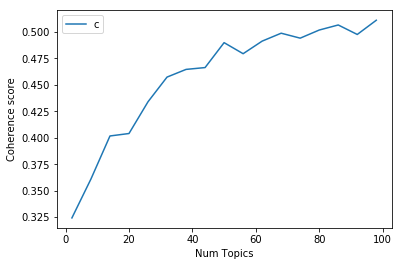

In [44]:
# Show graph
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [45]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3242
Num Topics = 8  has Coherence Value of 0.361
Num Topics = 14  has Coherence Value of 0.4017
Num Topics = 20  has Coherence Value of 0.404
Num Topics = 26  has Coherence Value of 0.4341
Num Topics = 32  has Coherence Value of 0.4574
Num Topics = 38  has Coherence Value of 0.4647
Num Topics = 44  has Coherence Value of 0.4664
Num Topics = 50  has Coherence Value of 0.49
Num Topics = 56  has Coherence Value of 0.4795
Num Topics = 62  has Coherence Value of 0.4914
Num Topics = 68  has Coherence Value of 0.4989
Num Topics = 74  has Coherence Value of 0.4942
Num Topics = 80  has Coherence Value of 0.5019
Num Topics = 86  has Coherence Value of 0.5067
Num Topics = 92  has Coherence Value of 0.4977
Num Topics = 98  has Coherence Value of 0.5112


In [46]:
# Select the model and print the topics
optimal_model = model_list[11]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(35,
  '0.022*"plus" + 0.011*"faire" + 0.008*"roi_mohammed" + 0.007*"etat" + '
  '0.006*"donne" + 0.006*"service" + 0.005*"apre" + 0.005*"direction" + '
  '0.005*"nouveau" + 0.005*"viande"'),
 (29,
  '0.011*"americain" + 0.011*"nouveau" + 0.011*"an" + 0.008*"connaître" + '
  '0.008*"demande" + 0.008*"plus" + 0.008*"moins" + 0.008*"plusieurs_region" + '
  '0.007*"entreprise" + 0.007*"roi_mohammed"'),
 (63,
  '0.012*"mettre" + 0.012*"royal" + 0.012*"vendredi" + 0.012*"roi_mohammed" + '
  '0.012*"direction" + 0.009*"attendre" + 0.009*"projet" + 0.008*"effet" + '
  '0.008*"gouvernement" + 0.008*"part"'),
 (44,
  '0.015*"roi_mohammed" + 0.010*"nouveau" + 0.010*"chef" + 0.008*"plus" + '
  '0.008*"faire" + 0.008*"direction" + 0.006*"octobre" + '
  '0.006*"plusieurs_region" + 0.006*"rendre" + 0.006*"tout"'),
 (34,
  '0.009*"province" + 0.009*"ville" + 0.009*"moins" + 0.006*"apre" + '
  '0.006*"suite" + 0.006*"eviter" + 0.006*"rapport" + 0.006*"octobre" + '
  '0.006*"organisation" + 0.006*"dev

# Trouver le sujet dominant dans chaque phrase :

L'une des applications pratiques de la modélisation de sujet est de déterminer de quel sujet traite un document donné.
Pour trouver cela, nous trouvons le numéro de topic qui a le pourcentage de contribution le plus élevé dans ce document.

In [47]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


In [48]:
df_tooptimal_model_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,42.0,0.8768,"ministre, affaires_etrangere, fille, connaître...",Suite à la diffusion d’une interview controver...
1,1,43.0,0.6716,"ville, plus, roi_mohammed, lors, nouveau, roya...",Casablanca a été classée 49e ville la plus acc...
2,2,16.0,0.9104,"alors, autorite, faire, personnel, championnat...","Invitée de l’émission web de Hespress ""Niqach ..."
3,3,48.0,0.8592,"roi_mohammed, venir, lors, americain, royaum, ...",Le roi Mohammed VI a adressé un message de fél...
4,4,34.0,0.8768,"province, ville, moins, apre, suite, eviter, r...",Des ménages grondent contre le renchérissement...
5,5,27.0,0.8592,"international, ville, roi_mohammed, vol, afric...",Dans le cadre de l’évaluation quantitative des...
6,6,26.0,0.9343,"plus, homme, ministre, an, venir, droit, membr...","Abderrahmane Youssoufi, ancien Premier ministr..."
7,7,63.0,0.8768,"mettre, royal, vendredi, roi_mohammed, directi...",Des vagues pouvant atteindre 4 à 6 mètres et d...
8,8,33.0,0.8358,"notamment, ete, roi_mohammed, pays, prevue, ju...",Considérées comme un patrimoine humain et natu...
9,9,6.0,0.8768,"plus, nouveau, faire, roi_mohammed, nombre, su...","Située au sud de Marrakech, la vallée de Drâa ..."


# Trouvez le document le plus représentatif pour chaque sujet
Parfois, seuls les mots-clés du sujet peuvent ne pas être suffisants pour donner un sens au sujet d'un sujet. Donc, pour vous aider à comprendre le sujet, vous pouvez trouver les documents auxquels un sujet donné a le plus contribué et en déduire le sujet en lisant ce document

In [26]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9552,"roi_mohammed, plus, vi, apre, personne, monde,...",Un large remaniement attend le Gouvernement ma...
1,1.0,0.9589,"roi_mohammed, apre, public, accident, mettre, ...",La réélection de Habib El Malki à la tête de l...
2,2.0,0.9648,"fin, gouvernement, securite, europeenn, main, ...",Le Ministre des Affaires étrangères veut mettr...
3,3.0,0.9635,"ministre, nouveau, direction, roi_mohammed, ve...","Au fil des ans, le Maroc a acquis le statut de..."
4,4.0,0.9531,"gouvernement, lors, roi_mohammed, message, vie...",Une circulaire vient d’être envoyée aux procur...


# Répartition des sujets entre les documents :
Nous voulons comprendre le volume et la distribution des sujets afin de juger de l'ampleur de la discussion

In [27]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,42.0,"ministre, affaires_etrangere, fille, connaître...",30.0,0.0167
1.0,43.0,"ville, plus, roi_mohammed, lors, nouveau, roya...",19.0,0.0105
2.0,16.0,"alors, autorite, faire, personnel, championnat...",19.0,0.0105
3.0,48.0,"roi_mohammed, venir, lors, americain, royaum, ...",37.0,0.0205
4.0,34.0,"province, ville, moins, apre, suite, eviter, r...",19.0,0.0105
...,...,...,...,...
1796.0,2.0,"fin, gouvernement, securite, europeenn, main, ...",NaN,NaN
1797.0,48.0,"roi_mohammed, venir, lors, americain, royaum, ...",NaN,NaN
1798.0,49.0,"venir, autorite, situation, algerie, partir, r...",NaN,NaN
1799.0,21.0,"ministre, direction, roi_mohammed, porte, anno...",NaN,NaN


In [24]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel